# Testing a simple peakbag (in PyMC3)

I need to obtain some preliminary results for TASC5, so I'm going to run a simplified peakbagging code with fewer bells and whistles.

- I will divide out the background best fit in advance
- I will not impose a complex prior on linewidth
- I will not apply a smoothness condition
- I will not impose a complex prior on mode heights

The expected effect of this will be, in order:

- Reduced quality inference on mode location
- Increased uncertainty on linewidths
- Risk of mode flipping on the $l = 0, 2$ pairs
- Increased runtime as the mode heights are less constrained

All these issues will be fixed before final publication and highlighted as caveats in the poster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

In [2]:
target = 3632418
mal = pd.read_csv('../../../data/malatium.csv', index_col=0)
idx = np.where(mal.KIC == target)[0][0]
star = mal.loc[idx]
kic = star.KIC
numax = star.numax
dnu = star.dnu

In [3]:
sfile = glob.glob('../../../data/*{}*.pow'.format(kic))
data = ascii.read(sfile[0]).to_pandas()
ff, pp = data['col1'].values, data['col2'].values

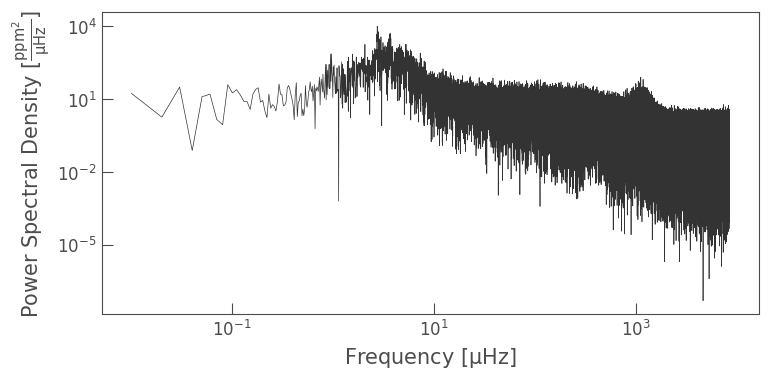

In [4]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
pg.plot(scale='log')

In [25]:
# Read in the mode locs
cop = pd.read_csv('../../../data/copper.csv',index_col=0)
cop = cop[cop.l != 3]
modelocs = cop[cop.KIC == str(kic)].Freq.values[27:32]
elocs = cop[cop.KIC == str(kic)].e_Freq.values[27:32]
modeids = cop[cop.KIC == str(kic)].l.values[27:32]

lo = modelocs.min() - .25*dnu
hi = modelocs.max() + .25*dnu

sel = (ff > lo) & (ff < hi)
f = ff[sel]
pf = pp[sel]

In [26]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

In [27]:
backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                    +str(kic)+'/*_fit.pkl')[0]
with open(backdir, 'rb') as file:
    backfit = pickle.load(file)
    
labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
res = np.array([np.median(backfit[label]) for label in labels])
res[0:6] = 10**res[0:6]

model = get_background(f, *res)    
p = pf / model

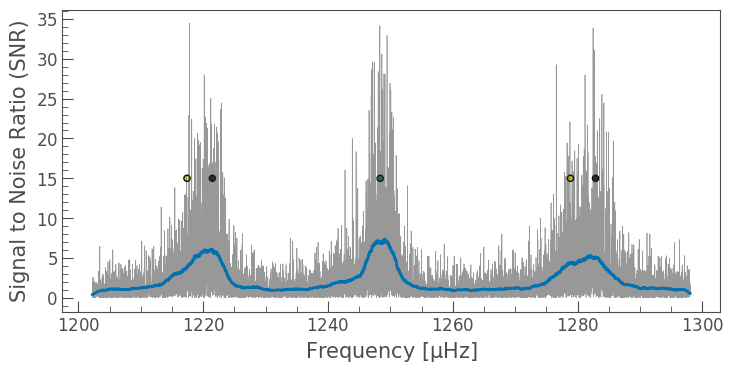

In [28]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

Set out the initial guesses

In [29]:
class model():
    def __init__(self, f, f0_, f1_, f2_):
        self.f = f
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]

        
    def epsilon(self, i, l, m):
    #I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.mod += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        b, f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i = p
        self.mod = np.ones(self.npts) * b
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        return self.mod
    
    def __call__(self, p):
        return self.model(p)

In [30]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]

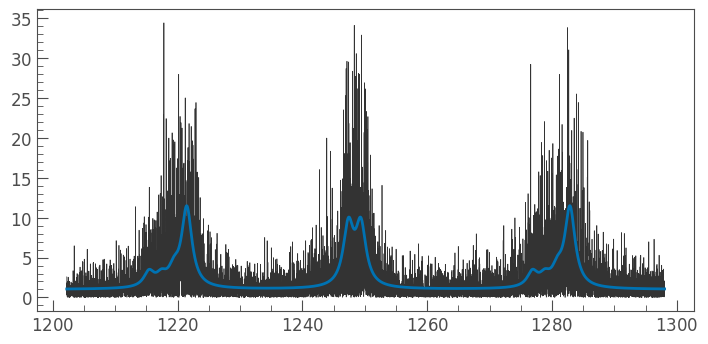

In [31]:
init = [1.,                          # Background
       f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.ones(len(f0_)) * 10.,     # l0 heights
       np.ones(len(f1_)) * 15.,     # l1 heights
       np.ones(len(f2_)) * 5.,      # l2 heights
       1.0,                         # splitting
       np.pi/2.]                         

mod = model(f, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod(init), lw=2)

In [32]:
pm_model = pm.Model()

with pm_model:
    b = pm.HalfNormal('b', sigma=2.0, testval=init[0])
    
    f0 = pm.Normal('f0', mu=f0_, sigma=f0_e, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=f1_e, testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=f2_e, testval=f2_, shape=len(f2_))
    
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init[4], shape=len(init[4]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[5], shape=len(init[5]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[6], shape=len(init[6]))
    
    h0 = pm.HalfNormal('h0', sigma=20., testval=init[7], shape=len(init[7]))
    h1 = pm.HalfNormal('h1', sigma=20., testval=init[8], shape=len(init[8]))
    h2 = pm.HalfNormal('h2', sigma=20., testval=init[9], shape=len(init[9]))
    
    split = pm.HalfNormal('split', sigma=2.0, testval=init[10])
    
    cosi = pm.Uniform('cosi', 0., 1.)
    
    i = pm.Deterministic('i', np.arccos(cosi))
    vcosi = pm.Deterministic('vcosi', cosi*split)
    
    fit = mod([b, f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [ ]:
with pm_model:
    trace = pm.sample(tune=500,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:NUTS: [cosi, split, h2, h1, h0, g2, g1, g0, f2, f1, f0, b]
Sampling 4 chains:  94%|█████████▍| 3779/4000 [04:05<00:08, 24.95draws/s]

In [ ]:
labels=['vcosi','cosi','i','split']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\sin(i)$',r'$\cos(i)$',r'$i$',r'$\nu_{\rm s}$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()


In [ ]:
pm.traceplot(trace, var_names=['b','cosi','i','split','g0','g1','g2','h0','h1','h2'])
plt.show()

In [ ]:
pm.summary(trace)

### Now let's plot some output evaluation:

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['b','f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i']
    res = np.array([np.median(trace[label],axis=0) for label in labels])
    ax.plot(f, mod(res), lw=2)

In [ ]:
import seaborn as sns
sns.distplot(p/mod(res))
sns.distplot(np.random.chisquare(2, size=10000)/2)